### Work division
#### The work for this notebook is done and compiled by Nemish Murawat.

### Libraries Required

In [1]:
# Import Requirements
import pandas as pd
from tqdm import tqdm as tq
from pre_processing_profiles import pre_processing_profiles
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

#### RQ-2.1 Plot the number of posts for each profile in descending order.

##### Approach: 
    
>#####    - To get the values for Number of posts by all the user I use profiles dataset to get the required values.  
>#####    - I read the profiles data in chunks of size=10000 and get the columns n_posts and profile_id.  
>#####    - I sort the obtained rows on the basis of values in n_posts column and sort them in descending order.
>#####    - I plot a scatter plot with Number of posts v/s Profile_id
    

46it [00:07,  6.45it/s]


Text(0, 0.5, 'Number of Posts')

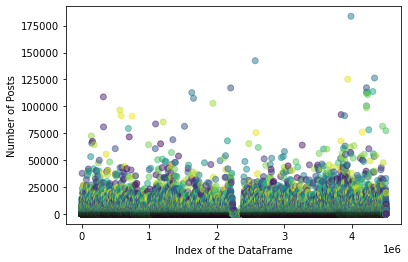

In [26]:

for j,i in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_profiles.csv',sep='\t',usecols=['profile_id','n_posts'],chunksize=100000))):
        i=i.dropna()
        df_nposts=pd.concat([df_nposts,pre_processing_profiles(i)],axis=0) if j!=0 else pre_processing_profiles(i)
        
colors=np.random.rand(len(df_nposts))
plt.scatter(y=df_nposts.n_posts.values,x=df_nposts.index,c=colors,alpha=0.5)
plt.xlabel('Index of the DataFrame')
plt.ylabel('Number of Posts')

###Scatter Plot/histogram 


#### RQ 2.2 What posts have the highest number of "likes"?
##### *Approach*:
>#####    - To get the values for Number of likes for all the posts I use posts dataset to get the required values.  
>#####    - I read the posts data in chunks of size=40000 and get the columns numbr_likes and post_id  
>#####    - I sort the obtained rows on the basis of values in nuber_likes column and sort them in descending order.
>#####    - I take the top post with highest number of likes for each chunk and combined all the top post for all the chunks in df_likes Dataframe.
>#####    - Finally,I sort the df_likes in descending order and retrive the post with highest likes among all the stores chunks top post.



In [2]:

for i,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_posts.csv',usecols=['post_id','numbr_likes'],sep='\t',chunksize=40000))):
       
    df_likes=pd.concat([df_likes,chunk.sort_values(by='numbr_likes',ascending=False).head(1)],axis=0) if i!=0 else chunk.sort_values(by='numbr_likes',ascending=False).head(1)
   

df_likes=df_likes.sort_values(by='numbr_likes',ascending=False)
print('The post with post-id {0} has {1} number of likes which is the maximum among the dataset'.format(str(df_likes['post_id'].head(1).values[0]),str(df_likes['numbr_likes'].head(1).values[0])))    

    

1068it [55:38,  3.13s/it]

The post with post-id Bt3yaXmAM0d has 8822952.0 number of likes which is the maximum among the dataset




#### RQ2.3 What posts have the most and the least number of comments?
#### *Approach*:
>#####    - To get the values for Number of likes for all the posts I use posts dataset to get the required values.  
>#####    - I read the posts data in chunks of size=10000 and get the columns number_comments and post_id  
>#####    - I sort the obtained rows on the basis of values in number_comments and sort them in descending order.
>#####    - I take the top post with highest number of cooments for each chunk and the post with least number of comment in sorted chunk using head() and tail() function.
>#####    - I store the highest comment in df_max_comment and least comments in df_min_comment. I combine all the values for all chunks in the respective DataFrame.
>#####    - Finally,I sort the df_max_comments in descending order to retrive the post with highest number of among all the stored chunks.
>#####    - Finally,I sort the df_min_comments in ascending order to retrive the post with least number of among all the stored chunks.



In [2]:
for i,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_posts.csv',usecols=['post_id','number_comments'],sep='\t',chunksize=10000))):
    chunk=chunk.dropna()     ###Remove NAN
    if i==0:
        df_max_comments=chunk.sort_values(by='number_comments',ascending=False).head(1) ##Sort chunk in Descending order and get the biggest value from chunk
        df_min_comments=chunk.sort_values(by='number_comments',ascending=False).tail(1)  ##Sort chunk in Descending order and get the lowest value from chunk
        
    else:
        i_max=chunk.sort_values(by='number_comments',ascending=False).head(1)
        i_min=chunk.sort_values(by='number_comments',ascending=False).tail(1)
        df_max_comments=pd.concat([df_max_comments,i_max],axis=0)     ##Concatenate data chunks of biggest values.I try to retain datafram structure to leverage dataframe functionalites for analysis.
        df_min_comments=pd.concat([df_min_comments,i_min],axis=0)
        
        
df_max_comments=df_max_comments.sort_values(by='number_comments',ascending=False)
print('The post with post-id {0} has {1} number of comments which is maximum among the dataset'.format(str(df_max_comments['post_id'].head(1).values[0]),str(df_max_comments['number_comments'].head(1).values[0])))    
df_min_comments=df_min_comments.sort_values(by='number_comments',ascending=True)
print('The post with post-id {0} has {1} number of comments which is minimum among the dataset'.format(str(df_min_comments['post_id'].head(1).values[0]),str(df_min_comments['number_comments'].head(1).values[0])))    

 

4272it [03:33, 19.98it/s]

The post with post-id Bx2sPAjHviO has 488953.0 number of comments which is maximum among the dataset
The post with post-id Bp1xEVPgpIe has 0.0 number of comments which is minimum among the dataset


#### RQ 2.4 How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results
#### *Approach*:
>#####    - To get the values for Number of likes for all the posts I use posts dataset to get the required values.  
>#####    - I read the posts data in chunks of size=10000 and get the columns location_id 
>#####    - Now for every chunk,I sum of all the rows with empty location_id and store into empty_location Variable
>#####    - Now for every chunk,I sum of all the rows with non empty location_id and store into non_empty_location Variable
>#####    - I extend the sum for both the varaibles over all the chunks.
>#####    - I plot a pie chart to to represent the precentage of tagged location v/s non-tagged Location


In [13]:
for i,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_posts.csv',usecols=['location_id'],sep='\t',chunksize=1000000))):
  empty_location =empty_location+chunk.isnull().sum() if i!=0 else chunk.isnull().sum()
  non_empty_location=non_empty_location+chunk.notnull().sum() if i!=0 else chunk.notnull().sum()

empty_location=empty_location.values[0]
non_empty_location=non_empty_location.values[0]  

43it [01:32,  2.15s/it]

[12972772] location_id    29737425
dtype: int64


([<matplotlib.patches.Wedge at 0x7f40d0598040>,
 [Text(0.8675127424281129, 1.2236918083099415, 'Non_Tagged Location =30.37%'),
  Text(-0.6361760951321633, -0.8973739331975232, 'Tagged_Location =69.63%')])

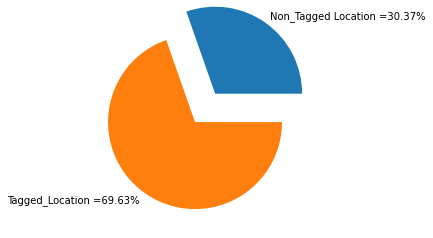

In [24]:
mylabels=['Non_Tagged Location ='+str(round(empty_location*100/(empty_location+non_empty_location),2))+'%','Tagged_Location ='+str(round(non_empty_location*100/(empty_location+non_empty_location),2))+'%']
plt.pie([round(empty_location*100/(empty_location+non_empty_location),2),round(non_empty_location*100/(empty_location+non_empty_location),2)],labels=mylabels,explode=[0.4,0])

### Comments:

##### This chart provides insight to the behaviour of the users. 

##### Most of the users in this dataset tend to use the features of location tagging to their posts. 

##### This can be attributed due to many reasons such as social habits,share the places that they visit(touristic,hidden places) and other possible explanations.


#### RQ 2.5 How many posts include only photos? How many also have videos?


#### *Approach*:

>#####    To get the values for Number of likes for all the posts I use posts dataset to get the required values.  
>#####    I read the posts data in chunks of size=10000 and get the columns post_type
>#####    Now for every chunk,I evaluate three things number of posts which are :
>>#####   Only Photos(column value=1)
>>#####   Only Videos(column value=2)
>>#####   Both Photos and Videos(column value=3)

>#####    I make a pie chart for the first two values and ignore the third parameter as it is very very small.


In [16]:
for i,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_posts.csv',usecols=['post_type'],sep='\t',chunksize=1000000))):
    
    if i==0:  
        count_photos=count_photos+len(chunk[chunk['post_type']==1]) if i!=0 else len(chunk[chunk['post_type']==1]) ##Filter by post_type column values to identify rows with only photos
        count_videos=count_videos+len(chunk[chunk['post_type']==2]) if i!=0 else len(chunk[chunk['post_type']==2])
        count_photos_videos=count_videos+len(chunk[chunk['post_type']==3]) if i!=0 else len(chunk[chunk['post_type']==3])
        
print('The total number of posts with only photos is {}'.format(count_photos))
      
print('The total number of posts with only videos is {}'.format(count_videos))

print('The total number of posts with photos and videos is {}'.format(count_photos_videos))

43it [01:32,  2.15s/it]

The total number of posts with only photos is 940326
The total number of posts with only videos is 59671
The total number of posts with photos and videos is 3


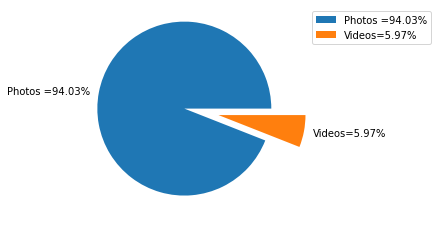

In [12]:
mylabels=['Photos ='+str(round(count_photos*100/(count_photos+count_videos),2))+'%','Videos='+str(round(count_videos*100/(count_photos+count_videos),2))+'%']
plt.pie([round(count_photos*100/(count_photos+count_videos),2),round(count_videos*100/(count_photos+count_videos),2)],labels=mylabels,explode=[0.4,0])
plt.legend(bbox_to_anchor=(1,0,0.5,1))
plt.show()



#### RQ 2.5 RQ2.6 What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?

#### *Approach*: 

>#####    For this part I take the profiles dataset and only read columns ['n_posts','followers','following','is_business_account']
>#####    I read the datasets in chunkws of size=10000 and use pre_processing_profiles which does the following thing:
>>#####   The rows of chunk with NaN values from 'is_business_account' replaces with False
>>#####   The rows of chunk with NaN values from 'followers' replaces with 0
>>#####   The rows of chunk with NaN values from 'following' replaces with 0
>>#####   The rows of chunk with NaN values from 'n_posts' replaces with 0

>#####    Now for every chunk,I identify users with buisness v/s Non buisness account using boolean logic and store them to count_true and count_false respectively.

>#####    In order to better understand the percentage of business v/s non_business account.I evaluate three more things:
>>#####   Number of followers, Number of users following and Number of posts for the business v/s non_business account
>>#####   Further a calculate average of followers, following and number of posts to get better understanding of the underlaying pictures.

>#####    I plot a pie plot for Business v/s Non-Business accounts. Further to better interpret these percentage, I plot a barplot average number of followers, users following and n_posts for business v/s non-business accounts.


In [3]:
for j,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_profiles.csv',sep='\t',usecols=['n_posts','followers','following','is_business_account'],chunksize=10000))):
    chunk=pre_processing_profiles(chunk)
    if j==0:
        count_true=len(chunk[chunk['is_business_account']==True].index)
        true_followers=chunk[chunk['is_business_account']==True]['followers'].sum()
        true_following=chunk[chunk['is_business_account']==True]['following'].sum()
        true_nposts=chunk[chunk['is_business_account']==True]['n_posts'].sum()

        
        count_false=len(chunk.index)-count_true
        false_followers=chunk[chunk['is_business_account']==False]['followers'].sum()
        false_following=chunk[chunk['is_business_account']==False]['following'].sum()
        false_nposts=chunk[chunk['is_business_account']==False]['n_posts'].sum()

    else:
        count_true+=len(chunk[chunk['is_business_account']==True].index)
        true_followers+=chunk[chunk['is_business_account']==True]['followers'].sum()
        true_following+=chunk[chunk['is_business_account']==True]['following'].sum()
        true_nposts+=chunk[chunk['is_business_account']==True]['n_posts'].sum()
        
        count_false+=len(chunk[chunk['is_business_account']==False].index)
        false_followers+=chunk[chunk['is_business_account']==False]['followers'].sum()
        false_following+=chunk[chunk['is_business_account']==False]['following'].sum()
        false_nposts+=chunk[chunk['is_business_account']==False]['n_posts'].sum()



451it [00:16, 26.90it/s]


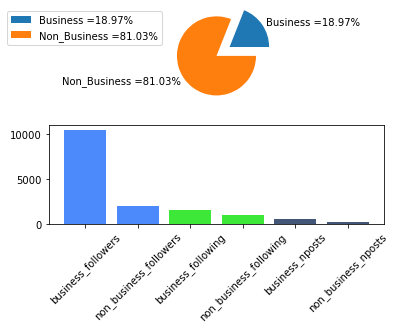

In [12]:

plt.subplot(2,1,1)
mylabels=['Business ='+str(round(count_true*100/(count_true+count_false),2))+'%','Non_Business ='+str(round(count_false*100/(count_true+count_false),2))+'%']
plt.pie([round(count_true/(count_true+count_false),2),round(count_false/(count_true+count_false),2)],labels=mylabels,explode=[0.4,0])
plt.legend(bbox_to_anchor=(-0.5,0,0.5,1))

plt.subplot(2,1,2)
colors=[]
for i in range(0,6,2):
        x=(random.random(), random.random(), random.random())
        colors.append(x)
        colors.append(x)
plt.bar([str('business_followers'),str('non_business_followers'),str('business_following'),str('non_business_following'),str('business_nposts'),str('non_business_nposts')],
        [true_followers/count_true,false_followers/count_false,true_following/count_true,false_following/count_false,true_nposts/count_true,false_nposts/count_false],color=colors)
plt.xticks(rotation=45)
plt.show()

##barh: horizontal bar plot

### Comments
#### On average though business account profiles account for 19% of the dataset they have a big reach in terms of people following their accounts when compared to non_business account which are 81% of the dataset.
#### Observation from bar plot
>#### Busness accounts have higher number of followers that Non-business accounts and hence their posts tend to have more affects on user's behaviours.

>#### Business accounts have higher number of accounts following that Non-business accounts and through this they might keep a track of user's buisness related posts. Further, accounts that are followed might also be buisness accounts through which they can keep track of products services created by other business.

>#### Busness accounts have higher number of posts that Non-business accounts and this might be attributed to have higher user engagement on their pages.
